# Hidden markov model (HMM)

The goal is to use to find looped and unlooped states in the data generated by Pavel's model.

We will use Gaussian model for emission. 
Given all the data we fit the all the parameters (gaussian parameters, transition probability between looped/unlooped).

Once we have the model, we use the model to predict the states.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hmmlearn import hmm
from matplotlib.backends.backend_pdf import PdfPages
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import glob

In [3]:
reproducible = True
distance_conversion = (0.015*np.sqrt(40)) # 1 a.u. = 0.08 um
if reproducible:
    np.random.seed(42)

# Training on simulated data

In [41]:
dataset_name = "211214_LE_17500_screened"
pdf = PdfPages(f"/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/{dataset_name}.pdf")
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/langevin_screened/screened_loop"
list_files = glob.glob(f"{basedir}/*/*/*/*/*/*dat")

df = pd.DataFrame(list_files, columns=["filename"])
df[['ctcf', 'speed', 'loading', 'unloading', 'rep']] = df["filename"].str.extract(r"screened_loop\/([\w+]*)\/([\d+]*)\/([\d]\.[\d+]*)\/([\d]\.[\d+]*)\/([\d+]*)\/", expand=True)
df['condition'] = df['speed'] + "." + df['loading'] + "_" + df['unloading'] 
df['uniqueid'] = "ctcf" + df['ctcf'] + "." + "rad21" + "on" + "_" + df['speed'] + "." + df['loading'] + "." + df['unloading'] + "." + df['rep']


In [42]:
basedir_control = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/control/"
list_files_control = glob.glob(f"{basedir_control}/*/*/*/*/*/*dat")

control = pd.DataFrame(list_files_control, columns=["filename"])
control[['ctcf', 'speed', 'loading', 'unloading', 'rep']] = control["filename"].str.extract(r"control\/([\w+]*)\/([\d+]*)\/([\d])\/([\d])\/([\d+]*)\/", expand=True)
control['condition'] = control['speed'] + "." + control['loading'] + "_" + control['unloading'] 
control['uniqueid'] = "ctcf" + control['ctcf'] + "." + "rad21" + "off" + "_" + control['speed'] + "." + control['loading'] + "." + control['unloading'] + "." + control['rep']


In [44]:
distances_control_original = pd.DataFrame()
for condition, sub2 in control.groupby('condition'):
    for uniqueid, sub1 in sub2.groupby('uniqueid'):
        for ct, sub in sub1.groupby("ctcf"):
            for file in sub.filename.unique():
                tmp = pd.read_csv(file, sep=" ")
                tmp.distance = tmp.distance * distance_conversion
                tmp['condition'] = condition
                tmp['frame'] = np.arange(len(tmp))
                tmp['uniqueid'] = uniqueid 
                tmp['ctcf'] = ct
                tmp['rad21'] = "on"
                distances_control_original = pd.concat([distances_control_original, tmp])

In [45]:
distances_original = pd.DataFrame()
for condition, sub2 in df.groupby('condition'):
    for uniqueid, sub1 in sub2.groupby('uniqueid'):
        for ct, sub in sub1.groupby('ctcf'):
            for file in sub.filename.unique():
                tmp = pd.read_csv(file, sep=" ")
                tmp.distance = tmp.distance * distance_conversion
                tmp['condition'] = condition
                tmp['frame'] = np.arange(len(tmp))
                tmp['uniqueid'] = uniqueid 
                tmp['ctcf'] = ct
                tmp['rad21'] = "off"
                distances_original = pd.concat([distances_original, tmp])

# Subsampling

In [46]:
subsample_every = 10
distances = distances_original.iloc[::subsample_every].copy()
distances_control = distances_control_original.iloc[::subsample_every].copy()
# distances.distance = distances.distance.values + np.random.normal(loc=0.17, scale=0.08, size=len(distances))
distances.frame = distances.frame.values / subsample_every
distances_control.frame = distances_control.frame.values / subsample_every

results = {}
seed = 0
for condition, sub in distances.groupby("condition"):
    traj2d = np.reshape(
        np.concatenate(
            [sub.distance.to_numpy(), distances_control.distance.to_numpy()]
        ),
        (-1, 1),
    )
    while True:
        model = hmm.GaussianHMM(
            n_components=2,
            covariance_type="full",
            min_covar=0.1,
            n_iter=10000,
            params="mtc",
            init_params="mtc",
        )

        # instead of fitting
        model.startprob_ = [0.5, 0.5]
        model.fit(traj2d)
        if all(sorted(model.means_) == model.means_):
            break
        seed += 1
        np.random.seed(seed)

    results[condition] = model

In [47]:
for key, model in results.items():
    means = (model.means_)
    sigmas = np.sqrt(model.covars_.squeeze())
    w = np.array(model.transmat_)
    logProb = model.score(traj2d)
    print(f"ctcf-speed-loading-unloading = {key}")
    print(f"Gaussian means: {means}")
    print(f"Gaussian std: {sigmas}")
    print(f"Transition rates: {w}")
    print("----------\n")

ctcf-speed-loading-unloading = 17500.0.01_0.001
Gaussian means: [[0.30170154]
 [0.70348606]]
Gaussian std: [0.12250407 0.18085771]
Transition rates: [[0.98175134 0.01824866]
 [0.01156559 0.98843441]]
----------



In [48]:
median = pd.DataFrame()
for cond in distances.condition.unique():
    distances_selected = distances[distances.condition == cond].copy()
    distances_selected.condition = distances_selected.uniqueid
    durations, second_passage_times, fraction_time, conditions, data = calculate_duration_second_passage_time(distances_selected, resolution = subsample_every, model = results[cond])
    tmp = pd.DataFrame(durations.groupby("cell_line").median()['contact_duration']).reset_index()
    tmp['second_passage_time'] = second_passage_times.groupby("cell_line").median()['second_passage_time'].values
    tmp['condition'] = cond + "_hmm"
    median = pd.concat([median, tmp])
    
median[["speed", "loading", "unloading"]] = median['condition'].str.extract(r"([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True)
median['ctcf'] = median['cell_line']

In [49]:
gaussian_means = pd.DataFrame()

for key, model in results.items():
    tmp = pd.DataFrame(model.means_, columns = ["gaussian_means"])
    tmp['state'] = ["looped", "unlooped"]
    tmp['condition'] = key
    gaussian_means = pd.concat([gaussian_means, tmp])
gaussian_means[["speed", "loading", "unloading"]] = gaussian_means['condition'].str.extract(r"([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True)


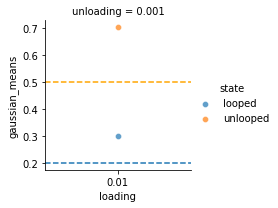

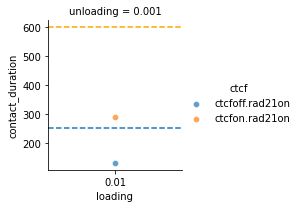

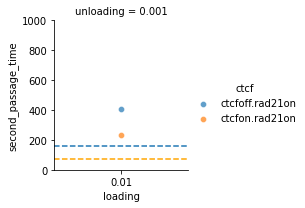

In [50]:
g = sns.FacetGrid(gaussian_means, col="unloading", hue="state")
g.map(sns.scatterplot, "loading", "gaussian_means", alpha=0.7)
g.add_legend()
for ax in g.axes[0]:
    ax.axhline(0.2, ls='--')
for ax in g.axes[0]:
    ax.axhline(0.5, ls='--', color='orange')
pdf.savefig(g.fig.figure)


g = sns.FacetGrid(median, col="unloading", hue="ctcf")
g.map(sns.scatterplot, "loading", "contact_duration", alpha=0.7)
g.add_legend()
for ax in g.axes[0]:
    ax.axhline(250, ls='--')

for ax in g.axes[0]:
    ax.axhline(600, ls='--', color='orange')
pdf.savefig(g.fig.figure)    

g = sns.FacetGrid(median, col="unloading", hue="ctcf")
g.map(sns.scatterplot, "loading", "second_passage_time", alpha=0.7)
g.add_legend()

for ax in g.axes[0]:
    ax.axhline(160, ls='--')

for ax in g.axes[0]:
    ax.axhline(70, ls='--', color='orange')
plt.ylim(0, 1000)
pdf.savefig(g.fig.figure)

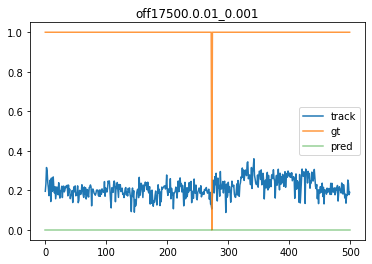

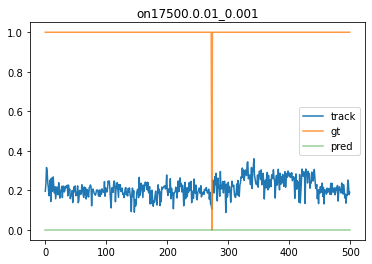

In [51]:
for cond in distances.condition.unique():
    distances_selected = distances[distances.condition == cond].copy()
    distances_selected.condition = distances_selected.uniqueid
    durations, second_passage_times, fraction_time, conditions, data = calculate_duration_second_passage_time(distances_selected, resolution = subsample_every, model = results[cond])
    for ctcf, sub in data.groupby("ctcf"):
        limit = 500
        fig = plt.figure()
        plt.plot(sub.frame.values[:limit], data.distance.values[:limit])
        plt.plot(sub.frame.values[:limit], 1-data.bond.values[:limit], alpha=0.8)
        plt.plot(sub.frame.values[:limit], data.prediction.values[:limit], alpha=0.5)
        plt.legend(['track', 'gt', 'pred'])
        plt.title(ctcf + cond)
        plt.show()
        pdf.savefig(fig)

In [52]:
pdf.close()